## 第一次小组作业
### 2020080301001 张力群

### 2020080301002 孔浩然

### 2020080301003 齐秋逸

### 作业要求
- 采用地图形式进行可视化展示
- 结合“行业板块.txt”，分析各地区的不同行业分布，选择适当方式展示结果；
- 通过聚类或其他方式进行分析，哪些地区具有较高相似性，即具有类似的行业分布？

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # 统计数据可视化
# 绘图风格： style= ["darkgrid"，"whitegrid"，"dark"，"white"，"ticks"]，默认darkgrid
sns.set_style(style="darkgrid")
# 颜色风格： themes = ['deep', 'muted', 'pastel', 'bright', 'dark', 'colorblind']
sns.set_palette(palette='bright')
ChinaFonts = {"黑体": "simhei", "宋体": "simsun", "华文楷体": "STKAITI"}
plt.rcParams["font.sans-serif"] = ChinaFonts["黑体"]  # 解决中文乱码问题
plt.rcParams["axes.unicode_minus"] = False  # 解决负号无法正常显示的问题
path_data = "/home/carton/workspace/python/Multivariate-statistical-analysis/database/第一次作业/"  # 设置 数据路径
path_pic = "/home/carton/workspace/python/Multivariate-statistical-analysis/save-database/第一次作业/"  # 设置 图像保存路径

### 第一题
利用pyecharts库将数据展示在地图上

In [2]:
regional_file = path_data + "地区板块.txt" # 板块分析结果文件名，含路径
df_regionalCode = pd.read_csv(regional_file, encoding="gbk", sep="\t", dtype=str,names=["板块代码", "板块名称", "股票代码", "股票名称"])


In [4]:
from pyecharts.globals import CurrentConfig, NotebookType
CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_LAB

from pyecharts.charts import Map
from pyecharts import options as opts
from pyecharts.globals import ThemeType  # 引入主题

In [5]:
# 将板块名称中的板块字样去掉
df_regionalCode["板块名称"] = df_regionalCode["板块名称"].str.replace("板块", "")
# 统计各省份股票数量
province_stock = df_regionalCode.groupby("板块名称")["股票代码"].count()
province_stock = province_stock.reset_index()
province_stock.columns = ["板块名称", "股票数量"]
province_stock = province_stock.sort_values(by="股票数量", ascending=False)
province_stock_count = province_stock["股票数量"].values.tolist()
province_stock_name = province_stock["板块名称"].values.tolist()
# 将内蒙改为内蒙古
province_stock_name = [i.replace("内蒙", "内蒙古") for i in province_stock_name]
rlist = [list(z) for z in zip(province_stock_name, province_stock_count)]

In [8]:
c = (
    Map(init_opts=opts.InitOpts(width="1000px",
        height="600px", theme=ThemeType.LIGHT))  # 可切换主题
    .set_global_opts(
        title_opts=opts.TitleOpts(title="各地区板块股票数目分布图"),
        visualmap_opts=opts.VisualMapOpts(
            min_=0,
            max_=700,
            range_text=['股票数量颜色区间:', ''],  # 分区间
            is_piecewise=True,  # 定义图例为分段型，默认为连续的图例
            pos_top="middle",  # 分段位置
            pos_left="left",
            orient="vertical",
            split_number=10,  # 分成10个区间
            is_show=True,
            is_calculable=True
        )
    )
    .add("province_stock_count", rlist, maptype="china")
#     .render("Map2.html")
)
c.load_javascript()

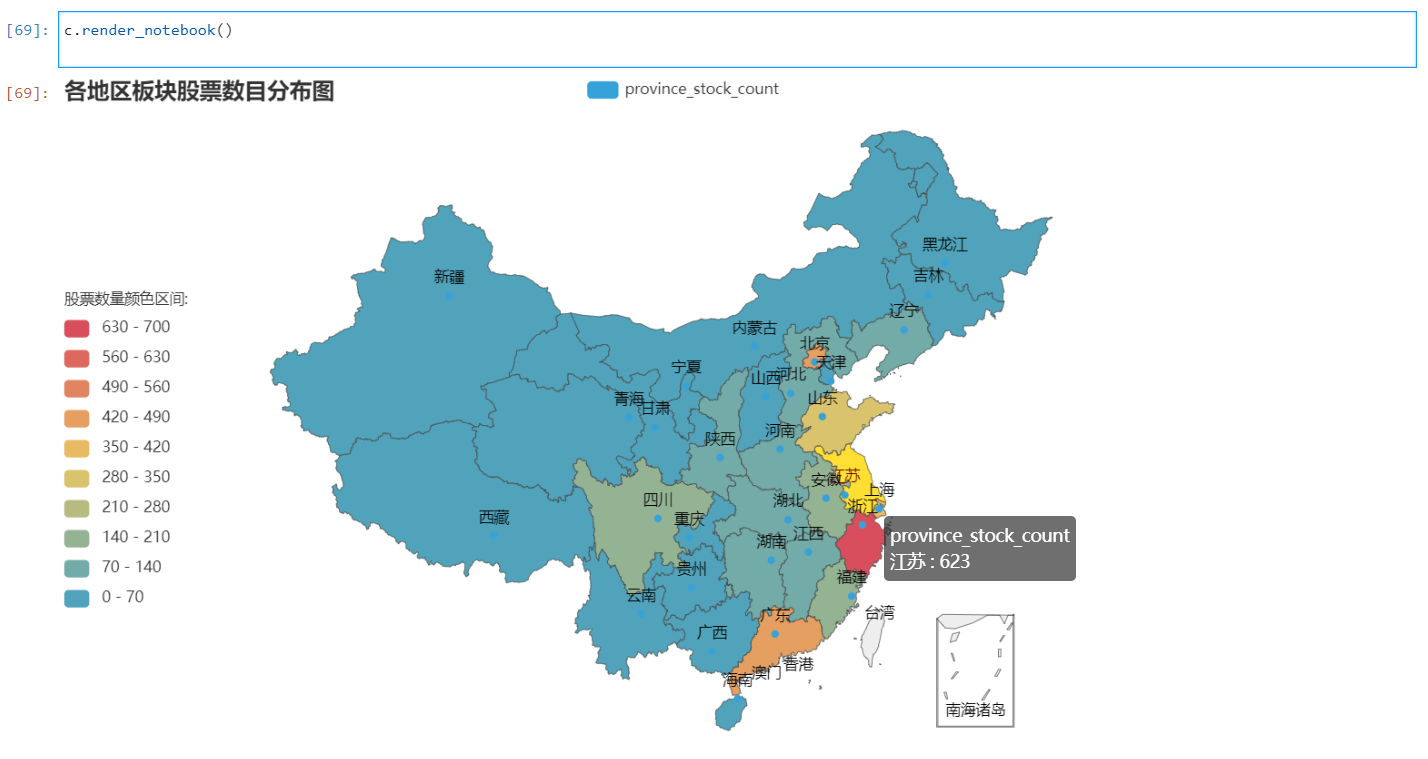

In [9]:
# c.render_notebook()
with open(path_data + "地区股票数量分布图.png", "rb") as f:
    png = f.read()
from IPython.display import Image
Image(png)

### 第二题
选取广东和山西进行展示，代表高密度和低密度的行业分布，分别用柱状图和饼状图展示

In [11]:
regional_file = path_data + "地区板块.txt"  # 板块分析结果文件名，含路径
df_regionalCode = pd.read_csv(regional_file, encoding="gbk", sep="\t", dtype=str, names=[
                              "地区代码", "地区名称", "股票代码", "股票名称"])
# 将板块名称中的板块字样去掉
df_regionalCode["地区名称"] = df_regionalCode["地区名称"].str.replace("板块", "")

sector_file = path_data + "行业板块.txt"  # 板块分析结果文件名，含路径
df_SectorCode = pd.read_csv(sector_file, encoding="gbk", sep=",", dtype=str, names=[
                            "行业代码", "行业名称", "股票代码", "股票名称"])

# 按照股票代码进行左连接
df_merge = pd.merge(df_regionalCode, df_SectorCode, on="股票代码", how="left")
# 只剩下地区代码、地区名称、行业代码、行业名称
df_merge = df_merge[["地区名称", "行业名称"]]

# 按地区分组
df_merge_regional = df_merge.groupby("地区名称")


# 将df_merge_regional转换为字典
df_merge_regional_dict = dict(list(df_merge_regional))
# print(df_merge_regional_dict)

# 筛选出广东，浙江，江苏的数据
df_guangdong = df_merge_regional_dict["广东"]
df_shanxi = df_merge_regional_dict["山西"]
df_xizang = df_merge_regional_dict["西藏"]

In [12]:
df_guangdong = df_guangdong[["行业名称"]]


<AxesSubplot: >

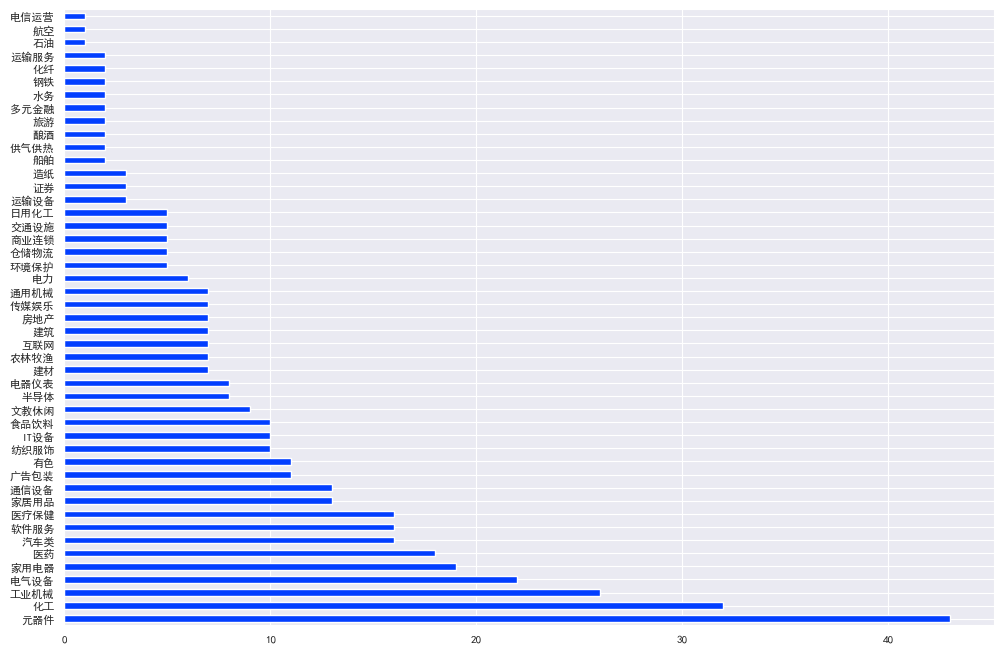

In [13]:
df_guangdong['行业名称'].value_counts().plot(kind="barh", fontsize=8, figsize=(12,8))

<AxesSubplot: ylabel='行业名称'>

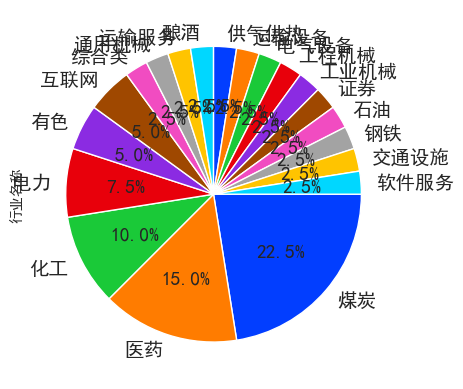

In [14]:
df_shanxi['行业名称'].value_counts().plot(kind="pie", autopct='%1.1f%%', 
counterclock=False, shadow=False, fontsize=14)

### 第三题
- 先对数据进行处理，形成地区行业分布表
- 采用kmeans方法进行聚类，用PCA得到两个主成分进行可视化处理
- 经过调参，最终结果展示聚类为4簇较为合理

In [15]:
df_total = pd.DataFrame(columns=["地区名称"])
df_total["地区名称"] = df_merge_regional_dict.keys()


In [16]:
sector_name = df_merge["行业名称"].unique()
sector_name = sector_name[~pd.isnull(sector_name)]


In [17]:
df_total[sector_name] = 0
df_total_columns = df_total.columns.tolist()

In [18]:
# 计算出df_merge_regional_dict中每个地区对应行业的数量
for key in df_merge_regional_dict.keys():
    # print(key)
    df = df_merge_regional_dict[key]
    # print(df)
    df_sector = df.groupby("行业名称")
    df_sector_dict = dict(list(df_sector))
    # print(df_sector_dict)
    for key_sector in df_sector_dict.keys():
        # print(key_sector)
        df_sector_dict[key_sector] = df_sector_dict[key_sector].shape[0]
        # print(df_sector_dict[key_sector])
        df_total.loc[df_total["地区名称"] == key,
                     key_sector] = df_sector_dict[key_sector]

In [19]:
df_total

,地区名称,纺织服饰,环境保护,汽车类,电气设备,化工,医药,工业机械,元器件,航空,...,家用电器,酒店餐饮,电信运营,广告包装,IT设备,船舶,保险,家居用品,日用化工,公共交通
0,上海,8,7,22,16,27,23,16,8,0,...,5,1,1,8,3,3,1,1,1,3
1,云南,0,0,2,1,3,6,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,内蒙,0,1,0,0,4,2,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,北京,7,16,12,11,4,24,11,9,9,...,2,2,6,5,4,4,3,1,0,0
4,吉林,0,1,6,2,1,9,2,0,0,...,0,0,0,0,0,0,0,0,0,0
5,四川,1,2,7,6,18,12,9,9,8,...,5,0,1,2,0,0,0,2,0,0
6,天津,1,3,4,3,3,8,4,3,0,...,0,0,0,2,2,0,0,0,0,0
7,宁夏,1,0,0,0,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,安徽,5,10,8,3,17,6,12,11,1,...,3,1,0,2,1,0,0,2,1,0
9,山东,8,8,20,15,39,15,15,4,2,...,4,0,0,3,2,0,0,2,1,0


In [20]:
colname = df_total_columns
# 将df_total中第2列到最后一列的数据转换为浮点数
df_total[df_total_columns[1:]] = df_total[df_total_columns[1:]].astype(float)

In [21]:
rawdata = df_total
pd.set_option('display.max_columns',None)#显示所有的列
pd.set_option('display.max_rows',None)#显示所有的行
pd.set_option('display.width',200)#为工不换行显示字段，增太横向显示宽度，。设置横向最大显示200字符

In [22]:
from sklearn.cluster import KMeans
x = rawdata.drop(['地区名称'],axis=1)#聚类需要所有变量为数值，因此删掉城市名
#x=pd.read_csv(path0, encoding='gbk',sep='\t')
kmeans = KMeans(n_clusters=4)# 初始化KMeans类
kmeans.fit(x)#训练模型
rawdata['cluster'] = kmeans.predict(x)#计算每个记录所属的簇

/opt/anaconda/envs/data-science/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [23]:
print (rawdata.cluster.value_counts())#查看每个簇的个数分布：

1    25
2     4
0     2
3     1
Name: cluster, dtype: int64


In [24]:
#聚类结果可视化
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
scaled_x = scale(x)#降维前数据标准化，降维效果更好
#PCA降维
pca = PCA(n_components=2)#指定降维后的维度为2维
pca.fit(scaled_x)# 训练PCA
tr = pca.transform(scaled_x)#将数据转换为2维


In [25]:
dataset = pd.concat([pd.DataFrame(tr),rawdata['cluster']],axis=1)
print (dataset)

            0          1  cluster
0    9.459868   4.192445        2
1   -3.485122   0.542646        1
2   -4.054959  -0.456228        1
3   11.128397  10.081925        3
4   -3.303870  -0.106476        1
5    0.261959   0.592383        1
6   -2.625190   0.194333        1
7   -4.347218  -0.009848        1
8    0.097196  -0.834506        1
9    4.064193  -3.171794        2
10  -3.649344   0.684205        1
11   7.947567  -1.725247        2
12  -3.118422  -0.144120        1
13  -2.427877   0.103748        1
14  12.729628  -2.677950        0
15  -2.426455  -0.098796        1
16  -2.736384  -0.589672        1
17  -1.872598  -1.625702        1
18  13.834555  -7.502517        0
19  -3.711757   0.158348        1
20   5.006370   2.539278        2
21  -0.842850   1.071767        1
22  -0.131477  -0.680702        1
23  -3.617638  -0.331791        1
24   0.502313  -1.074024        1
25  -4.183258   0.098620        1
26  -3.875701   0.119318        1
27  -2.116874  -0.199923        1
28  -2.413902 

In [26]:
c0 = dataset[dataset['cluster'] == 0]#筛选出簇类别为0的记录
c1 = dataset[dataset['cluster'] == 1]
c2 = dataset[dataset['cluster'] == 2]
c3 = dataset[dataset['cluster'] == 3]


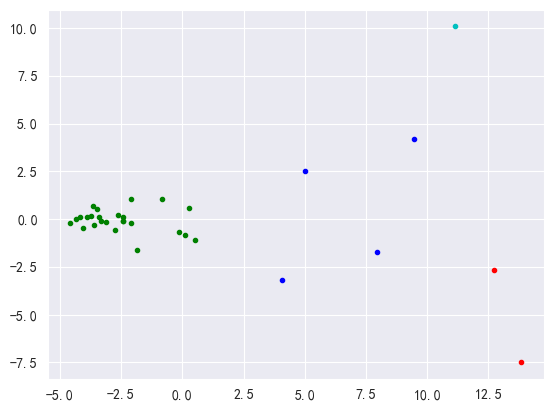

In [27]:
import matplotlib.pyplot as pLt
plt.plot(c0[0],c0[1],'r.',c1[0],c1[1],'g.',c2[0],c2[1],'b.', c3[0],c3[1],'c.')#将3个簇绘制到一-张图上。